# Notebook de prueba: toolbox_ML con Titanic

En este ejercicio, al ser yo sola e ir retrasada con las entregas, voy a dejar este notebook bien documentado, a modo presentación del curso. 


Vamos a probar las funciones de `toolbox_ML.py` usando el dataset de Titanic.
Como Titanic es un dataset típico de **clasificación** (sobrevive o no), algunas funciones de **regresión**
solo se pueden probar usando otro target numérico (por ejemplo `Fare`).

### Imports

In [3]:
import pandas as pd
import numpy as np
import toolbox_ML as tb

### 1) Cargar dataset Titanic
Cargamos el archivo y miramos tamaño y primeras filas.

In [5]:
DATA_PATH = "titanic.csv"   # <-- CAMBIA ESTO por tu ruta real
df = pd.read_csv(DATA_PATH)

print("El tanmaño del dataset es: ",df.shape)
df.head()

El tanmaño del dataset es:  (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### 2) Uso de la función describe_df
Resumen rápido: tipos, nulos, valores únicos y % de cardinalidad.

In [6]:
tb.describe_df(df)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
tipo,int64,int64,object,float64,int64,int64,float64,object,object,object,bool,object,object,object,bool
%_nulos,0.0,0.0,0.0,19.87,0.0,0.0,0.0,0.22,0.0,0.0,0.0,77.22,0.22,0.0,0.0
valores_unicos,2,3,2,88,7,7,248,3,3,3,2,7,3,2,2
%_cardinalidad,0.22,0.34,0.22,9.88,0.79,0.79,27.83,0.34,0.34,0.34,0.22,0.79,0.34,0.22,0.22


Aquí usamos `describe_df` para sacar un **resumen rápido** de todas las columnas del Titanic:  
tipo de dato, **% de nulos**, **nº de valores únicos** y **% de cardinalidad**.

**Cosas que se ven claramente:**
- La mayoría de columnas no tienen nulos, pero **`age`** tiene bastantes (≈ **19.87%**), así que habría que decidir si **imputamos** (media/mediana) o eliminamos filas.
- **`deck`** tiene muchísimos nulos (≈ **77.22%**), así que probablemente:
  - o se elimina la columna,
  - o se trata como "desconocido" (pero con tanto nulo igual no compensa).
- Variables como **`survived`**, **`sex`**, **`alive`**, **`alone`** tienen **2 valores únicos**, así que son **binarias**.
- Variables como **`pclass`**, **`embarked`**, **`class`**, **`who`** tienen pocos valores únicos (3 aprox), así que son **categóricas**.
- **`fare`** tiene muchos valores únicos (248) y una cardinalidad bastante mayor que el resto, así que se comporta como **numérica continua**.
- **`sibsp`** y **`parch`** tienen pocos valores únicos (7), o sea, son numéricas pero más bien **discretas** (cuentas).

En resumen, esta función nos ayuda a detectar rápido **dónde hay nulos importantes** y **qué tipo de variables tenemos** antes de hacer cualquier modelo.

### 3) Uso de `tipifica_variables(df, ...)`

Esta función intenta "poner etiqueta" a cada variable según su cardinalidad:
- si tiene 2 valores -> Binaria
- si tiene pocos valores únicos -> Categórica
- si tiene muchos valores únicos -> Numérica (continua o discreta según el % de cardinalidad)

Esto es orientativo pero ayuda a organizar el dataset antes de modelar.


In [7]:
tb.tipifica_variables(df, umbral_categoria=10, umbral_continua=10)


,nombre_variable,tipo_sugerido
0,survived,Binaria
1,pclass,Categórica
2,sex,Binaria
3,age,Numerica Discreta
4,sibsp,Categórica
5,parch,Categórica
6,fare,Numerica Continua
7,embarked,Categórica
8,class,Categórica
9,who,Categórica


Aquí usamos `tipifica_variables` para que nos sugiera **qué tipo de variable parece ser cada columna** según
cuántos valores distintos tiene (cardinalidad) y el % de cardinalidad.

Con estos umbrales (`umbral_categoria=10` y `umbral_continua=10`) salen cosas bastante lógicas:

- **Binarias**: `survived`, `sex`, `adult_male`, `alive`, `alone`  
  → tienen 2 valores posibles, así que encajan perfecto como variables binarias.

- **Categóricas**: `pclass`, `sibsp`, `parch`, `embarked`, `class`, `who`, `deck`, `embark_town`  
  → tienen pocos valores únicos (menos de 10), así que se tratan como categorías.  
  En especial `pclass`, `embarked` o `deck` tiene sentido que sean categóricas.

- **Numérica continua**: `fare`  
  → tiene muchos valores distintos y un % de cardinalidad alto, por eso la marca como continua (como un precio).

- **Numérica discreta**: `age`  
  → aquí la detecta como discreta con estos umbrales. En realidad `age` suele tratarse como continua,
  pero como en el dataset hay valores repetidos y el % de cardinalidad no es tan alto, el criterio la mete en discreta.
  (Esto nos recuerda que la función es **orientativa**, y los umbrales influyen bastante.)

En resumen: esta salida sirve para tener una idea rápida de cómo tratar las columnas antes de hacer análisis o modelos,
pero si algo no encaja (como `age`), se puede ajustar el umbral o decidirlo manualmente.


### 4) Uso de `get_features_num_regression(df, TARGET, ...)`: 

Elegimos un target numérico para probar las funciones de regresión

Estas funciones están pensadas para regresión, así que necesitamos un target numérico.
En Titanic usamos `fare`.


In [8]:
num_feats = tb.get_features_num_regression(df, "fare", umbral_corr=0.2)
num_feats


['survived', 'pclass', 'parch']

Aquí estamos probando la función con **`fare` como target**, porque es una variable numérica y así tiene sentido
hablar de regresión (en Titanic, `survived` sería más bien clasificación).

La función calcula la **correlación de Pearson** entre `fare` y el resto de columnas numéricas, y se queda con las
que cumplen `|corr| > 0.2`.

En este caso han salido:
- **`pclass`**: tiene sentido, porque la clase del billete está muy relacionada con el precio (1ª clase suele ser más cara).
- **`parch`**: también puede tener relación, porque viajar con familia (padres/hijos a bordo) puede estar asociado a tipos de billete/precios.
- **`survived`**: puede salir porque la supervivencia está relacionada indirectamente con clase/precio (pero ojo, `survived` no es un predictor “numérico continuo”, es binario).

Importante: esta función solo mira correlación lineal y además solo con variables **numéricas**, así que es una selección rápida,
no una conclusión definitiva.


### 5) Uso de `plot_features_num_regression(df, TARGET, ...)`:
Hace lo mismo que la anterior (filtra por correlación), pero además dibuja gráficos tipo pairplot para ver la relación entre `Fare` y las variables numéricas seleccionadas.

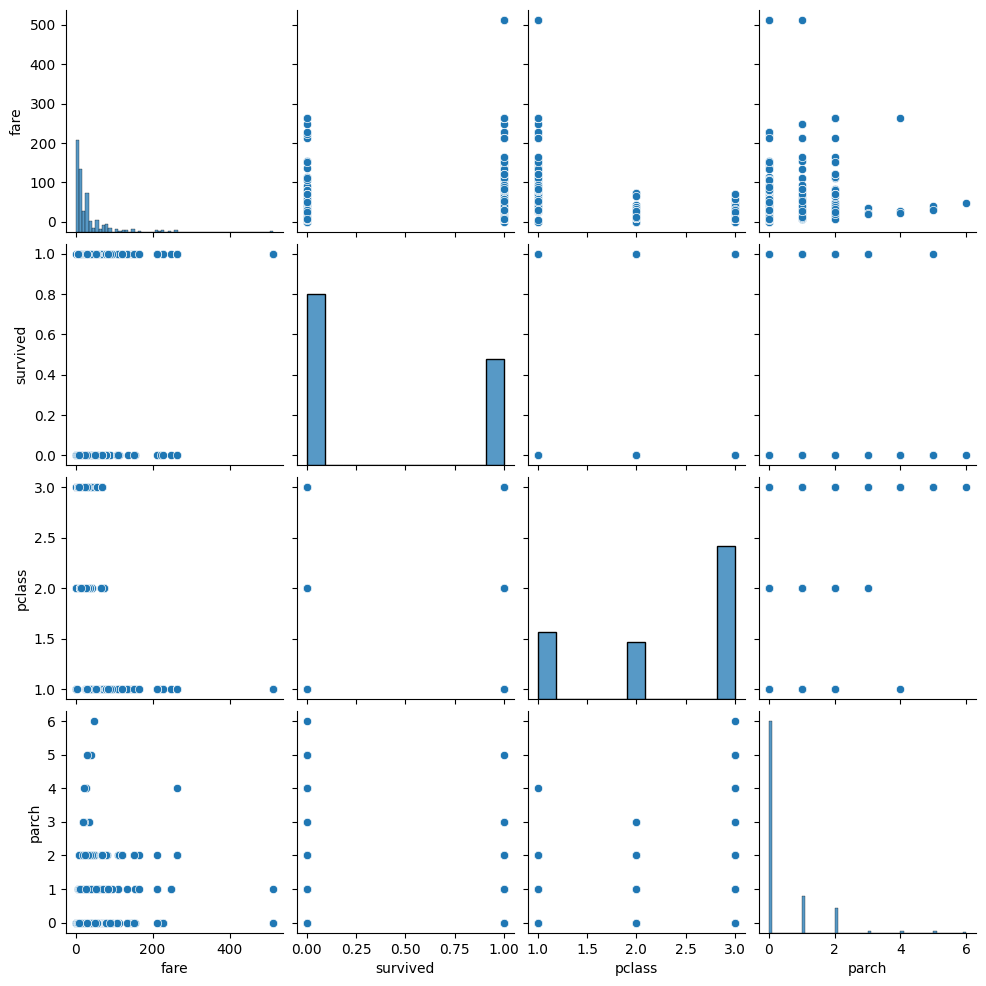

['survived', 'pclass', 'parch']

In [9]:
tb.plot_features_num_regression(df, "fare", umbral_corr=0.2)


Esta función es como la anterior (`get_features_num_regression`) pero además **pinta gráficos** para ver
si la relación tiene sentido “a ojo”.

En el pairplot se ven varias cosas:

- En la diagonal aparece la distribución de cada variable.
  Por ejemplo, **`fare`** está muy sesgada: la mayoría de precios son bajos y hay pocos muy altos.

- En los gráficos de dispersión:
  - **`pclass` vs `fare`** se nota bastante: los puntos de 1ª clase suelen tener `fare` más alto,
    y en 3ª clase se concentra más en precios bajos.
  - **`survived` vs `fare`** sale porque `survived` se metió como numérica (0/1), entonces el gráfico
    se ve como “dos líneas”. Se puede intuir que en algunos rangos de `fare` hay más supervivientes,
    pero esto realmente es más tema de clasificación.
  - Con **`parch`** se ven grupos porque también es discreta (valores enteros), no es continua.

En resumen: este gráfico nos sirve para comprobar visualmente que lo que seleccionó la correlación
tiene sentido (por ejemplo `pclass` con `fare`), y también para ver que algunas variables son discretas
y por eso salen “en columnas” de puntos.


### 6) Uso de `get_features_cat_regression(df, TARGET, ...)`

Ahora buscamos columnas **categóricas** que estén relacionadas con el target numérico (`Fare`).

La función hace un test estadístico y se queda con las variables cuyo p-valor es <= al umbral.


In [10]:
cat_feats = tb.get_features_cat_regression(df, "fare", pvalue=0.05)
cat_feats


['sex',
 'embarked',
 'class',
 'who',
 'adult_male',
 'deck',
 'embark_town',
 'alive',
 'alone']

Aquí buscamos **variables categóricas** que estén relacionadas con el target numérico **`fare`**.
La función agrupa `fare` por cada categoría y hace un **test estadístico** para ver si hay diferencias
entre grupos. Si el **p-valor** sale `<= 0.05`, la variable se considera “relacionada” y se devuelve.

En este caso han salido:
- `sex`, `who`, `adult_male` → pueden estar relacionados porque algunos perfiles viajaban más en ciertas clases/tipos de billete.
- `class` y `embarked` / `embark_town` → tiene sentido: la clase y el puerto influyen bastante en el precio.
- `deck` → también puede tener relación, aunque en Titanic esta columna tiene muchos nulos (en `describe_df` se veía),
  así que hay que tener cuidado con la interpretación.
- `alive` y `alone` → `alive` básicamente repite info de `survived`, y `alone` puede estar relacionado con el tipo de billete.

En resumen: esta función nos da una lista de **categóricas “significativas”** respecto al precio,
pero no significa causalidad, solo que hay diferencias en `fare` según las categorías.


### 7) Uso de `plot_features_cat_regression(df, TARGET, ...)`

Esta función dibuja histogramas del target numérico (`fare`) separados por categorías para las variables que han salido ignificativas en la función anterior.

Lo usamos con `with_individual_plot=False` para que no genere mil gráficos.


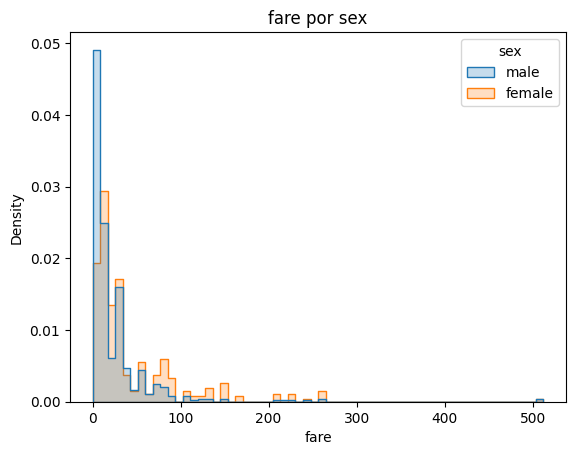

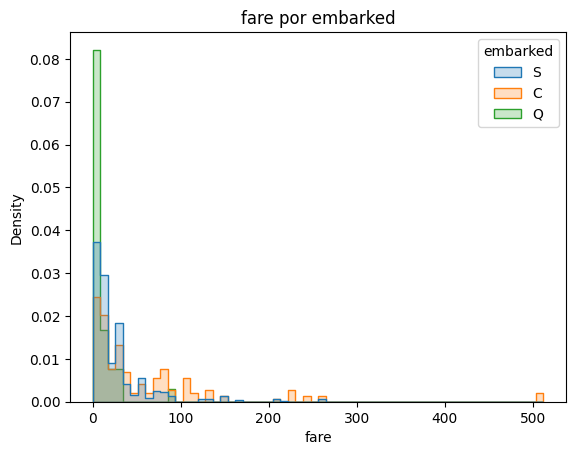

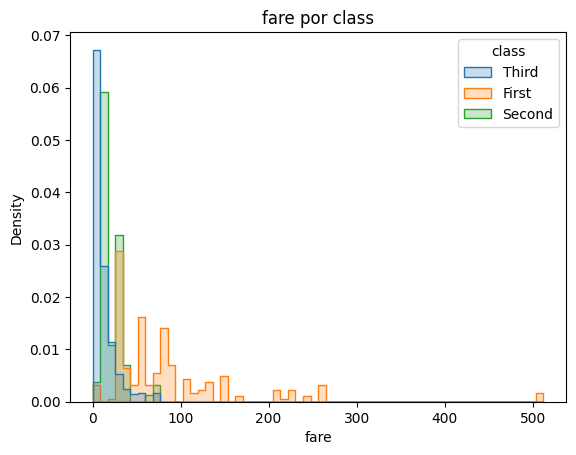

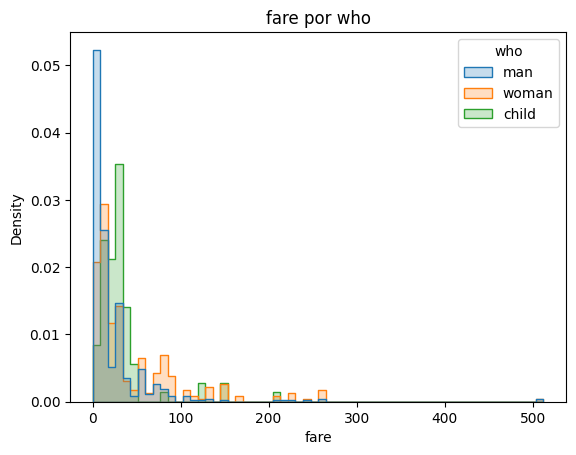

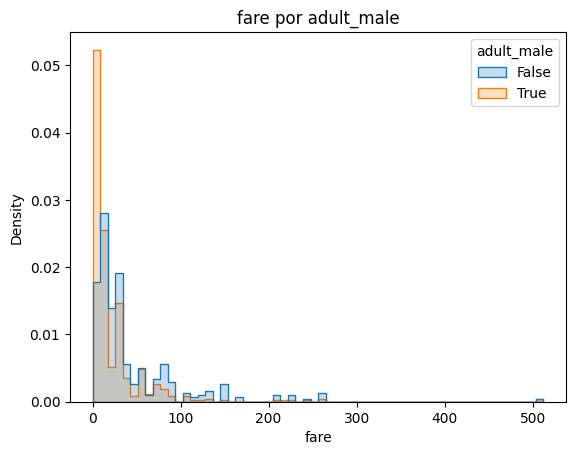

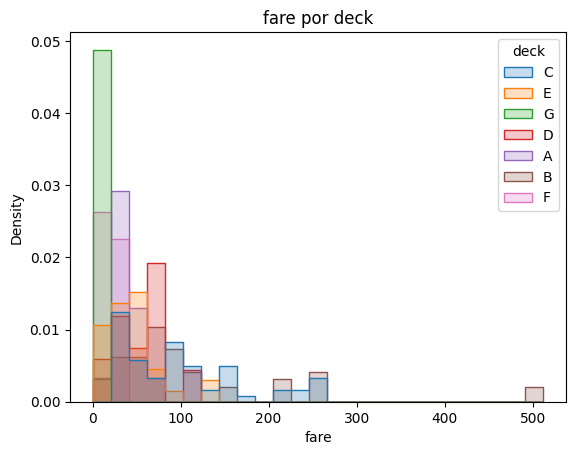

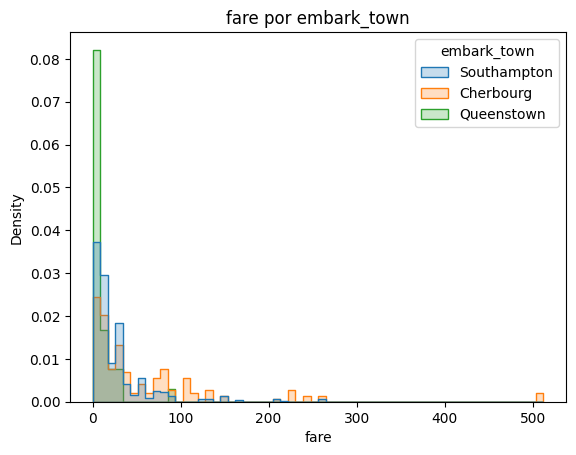

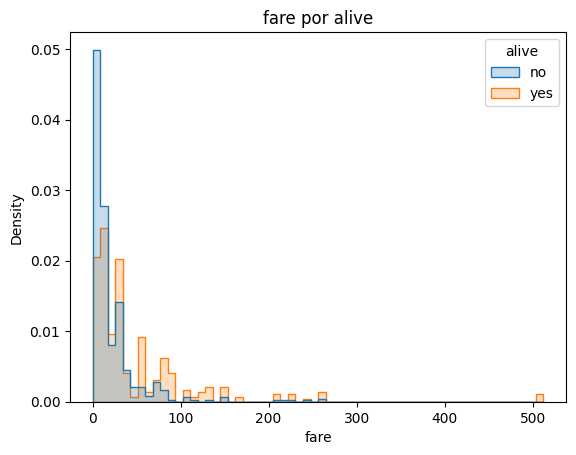

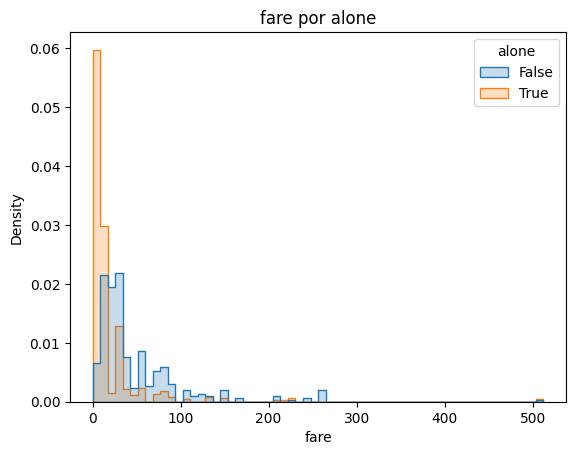

['sex',
 'embarked',
 'class',
 'who',
 'adult_male',
 'deck',
 'embark_town',
 'alive',
 'alone']

In [11]:
tb.plot_features_cat_regression(df, "fare", pvalue=0.05, with_individual_plot=False)


En esta parte usamos la función para **visualizar** las variables categóricas que antes salieron como
“significativas” para explicar `fare`.  
La idea es simple: para cada columna categórica, se dibuja la distribución de `fare` separada por categorías
(colores distintos).

**Cosas que se ven en las gráficas:**

- **`fare` está muy sesgada** (muchos billetes baratos y pocos muy caros). Por eso casi todo está pegado a la izquierda
  y hay algunos valores súper altos.

- **`class`**: es la más clara.
  - *First* tiene precios mucho más altos.
  - *Third* se concentra en precios bajos.
  Esto explica perfectamente por qué `class` sale como significativa.

- **`embarked` / `embark_town`**:
  Se nota que los precios cambian según el puerto (por ejemplo Cherbourg suele tener más billetes caros que otros),
  así que tiene sentido que salga.

- **`sex`, `who`, `adult_male`**:
  No es que “ser hombre/mujer” cambie el precio directamente, pero sí se ve que hay diferencias en la distribución,
  probablemente porque está relacionado con la **clase** y el tipo de billete (es un efecto indirecto).

- **`alone`**:
  También aparecen diferencias: la gente que viaja sola y la que no, no tiene exactamente la misma distribución de precios.

- **`alive`**:
  Sale porque está muy relacionado con `survived` (prácticamente es lo mismo). No es una variable “de precio” como tal,
  pero puede verse diferencia de `fare` entre grupos por la relación con la clase.

- **`deck`**:
  Aquí hay que tener cuidado, porque en `describe_df` vimos que `deck` tiene muchísimos nulos.
  La gráfica se hace con las filas que sí tienen `deck`, así que la muestra es más pequeña, pero aun así se ve que
  algunas cubiertas están asociadas a precios más altos.

**En resumen:** estos gráficos ayudan a ver “a ojo” por qué el test estadístico detectó relación:
para varias variables, las distribuciones de `fare` cambian bastante según la categoría (sobre todo `class`).


## Conclusión final

- `describe_df` y `tipifica_variables` nos sirven para explorar el dataset rápido (tipos, nulos, etc).
- Para probar las funciones de regresión usamos `Fare` como target numérico.
- Con eso podemos ver qué variables numéricas/categóricas están más relacionadas con el precio.
- `Survived` sería para clasificación, así que no lo usamos como ejemplo principal.
